In [46]:
from keras.models import load_model
import pandas as pd
import pickle
import tensorflow as tf
import numpy as np
import keras
import matplotlib.pyplot as plt
import shap
import seaborn as sns
import os
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve

In [47]:
## List of models
print("\n".join([f for f in os.listdir("../../models/TopoDNN/topodnnmodels/")]))

topodnnmodel_v3
topodnnmodel_v4
topodnnmodel_standardize_pt
topodnnmodel_30
topodnnmodel_v1
topodnnmodel_v2
topodnnmodel_pt
topodnnmodel
topodnnmodel_pt0


In [48]:
#Loading data
df_test = pd.read_pickle("../../datasets/topoprocessed/test.pkl")
labels = np.array(df_test.loc[:,df_test.columns == 'is_signal_new']).reshape(-1)
df_test = df_test.loc[:,df_test.columns != 'is_signal_new']




In [49]:
def NeuronFiringEvaluator(model, x):
    FiringEvaluator = []
    layer_tags = []
    for ii, layer in enumerate(model.layers):
        x = layer(x)
        if 'activation' in layer.name and ii < len(model.layers) - 1:
            FiringEvaluator.append(np.array(tf.math.reduce_sum(x, 0)))
            layer_tags.append("Layer " + str(len(FiringEvaluator)))
    return FiringEvaluator, layer_tags

In [50]:
def ActivationMapPlotter(FiringMatrix_0, FiringMatrix_1, layer_tags, tag='baseline', save=False):
    tag = 'baseline' if tag == ''else tag.strip('_')
    N_cols = len(FiringMatrix_0)
    N_rows = max([len(i) for i in FiringMatrix_0])
    Nnodes = 0
    for ii in range(len(FiringMatrix_0)):
        max_0 = FiringMatrix_0[ii].max()
        max_1 = FiringMatrix_1[ii].max()
        FiringMatrix_0[ii] = FiringMatrix_0[ii]/max_0
        FiringMatrix_1[ii] = FiringMatrix_1[ii]/max_1
        Nnodes += len(FiringMatrix_0[ii])
    for ii in range(N_cols):
        if len(FiringMatrix_0[ii]) < N_rows:
            FiringMatrix_0[ii] = np.append(FiringMatrix_0[ii], 
                                           np.ones(N_rows - len(FiringMatrix_0[ii]))*np.nan)
            FiringMatrix_1[ii] = np.append(FiringMatrix_1[ii], 
                                           np.ones(N_rows - len(FiringMatrix_1[ii]))*np.nan)
    
    FiringMatrix_0 = np.array(FiringMatrix_0)
    FiringMatrix_1 = np.array(FiringMatrix_1)
    s0 = np.sum(FiringMatrix_0 < 0.2)/Nnodes
    s1 = np.sum(FiringMatrix_1 < 0.2)/Nnodes
    sall = np.sum(np.maximum(FiringMatrix_0, FiringMatrix_1) < 0.2)/Nnodes
    print("Sparsity measure (RNA < 0.2) for background jets: ", s0)
    print("Sparsity measure (RNA < 0.2) for signal jets: ", s1)
    print("Overall sparsity measure (RNA < 0.2): ", sall)
    ## The relative node firing rates for class 0 are multiplied by a factor of -1
    ## to represent the NAPs of two classes side by side for a visual comparison
    weights = np.append(-1*FiringMatrix_0.reshape(-1), FiringMatrix_1.reshape(-1)) 
    x = np.array([np.arange(N_cols)]*N_rows).T.reshape(-1) + 0.25
    x = np.append(x, np.array([np.arange(N_cols)]*N_rows).T.reshape(-1) + 0.75)
    y = np.array([np.arange(N_rows)]*N_cols).reshape(-1) + 0.5
    y = np.append(y,y)
    
    fig, axes = plt.subplots(1,1,figsize=(20,20))
    _,_,_,im = axes.hist2d(x,y,
                   bins=[np.arange(0,N_cols+0.25,0.5), np.arange(N_rows+1)],
                   weights = weights, cmap = 'bwr', cmin = -1, cmax = 1)
    axes.set_facecolor('grey')

    cbar = fig.colorbar(im, ax=axes)
    cbar.ax.tick_params(labelsize=40) 
    axes.set_xlabel('Network Activation Layers', fontsize = 40)
    axes.set_ylabel('Node in hidden layer', fontsize = 40)
    axes.set_xticks(np.arange(N_cols) + 0.5) 
    axes.set_xticklabels(layer_tags, rotation='vertical',  fontsize=40)
    axes.tick_params(axis='both', which='major', labelsize=40)
    plt.tight_layout()
    if save:
        plt.savefig("figures/NAP_TopoDNN_{}.png".format(tag))
    plt.show()
    
    
    fig, axes = plt.subplots(1,1,figsize=(20,20))
    weights = np.abs(FiringMatrix_1.reshape(-1) - FiringMatrix_0.reshape(-1))
    x = np.array([np.arange(N_cols)]*N_rows).T.reshape(-1) + 0.5
    y = np.array([np.arange(N_rows)]*N_cols).reshape(-1) + 0.5
    _,_,_,im = axes.hist2d(x,y,
                   bins=[np.arange(N_cols+1), np.arange(N_rows+1)],
                   weights = weights, cmap = 'Reds')

    cbar = fig.colorbar(im, ax=axes)
    cbar.ax.tick_params(labelsize=40) 
    axes.set_facecolor('grey')
    axes.set_xlabel('Network Activation Layers', fontsize=40)
    axes.set_ylabel('Node in hidden layer', fontsize=40)
    axes.set_xticks(np.arange(N_cols) + 0.5)
    axes.set_xticklabels(layer_tags, rotation='vertical', fontsize=40)
    axes.tick_params(axis='both', which='major', labelsize=40)
    plt.tight_layout()
    if save:
        plt.savefig("figures/dNAP_TopoDNN_{}.png".format(tag))
    plt.show()
    return (s0, s1, sall)

Sparsity measure (RNA < 0.2) for background jets:  0.8571428571428571
Sparsity measure (RNA < 0.2) for signal jets:  0.7571428571428571
Overall sparsity measure (RNA < 0.2):  0.7047619047619048


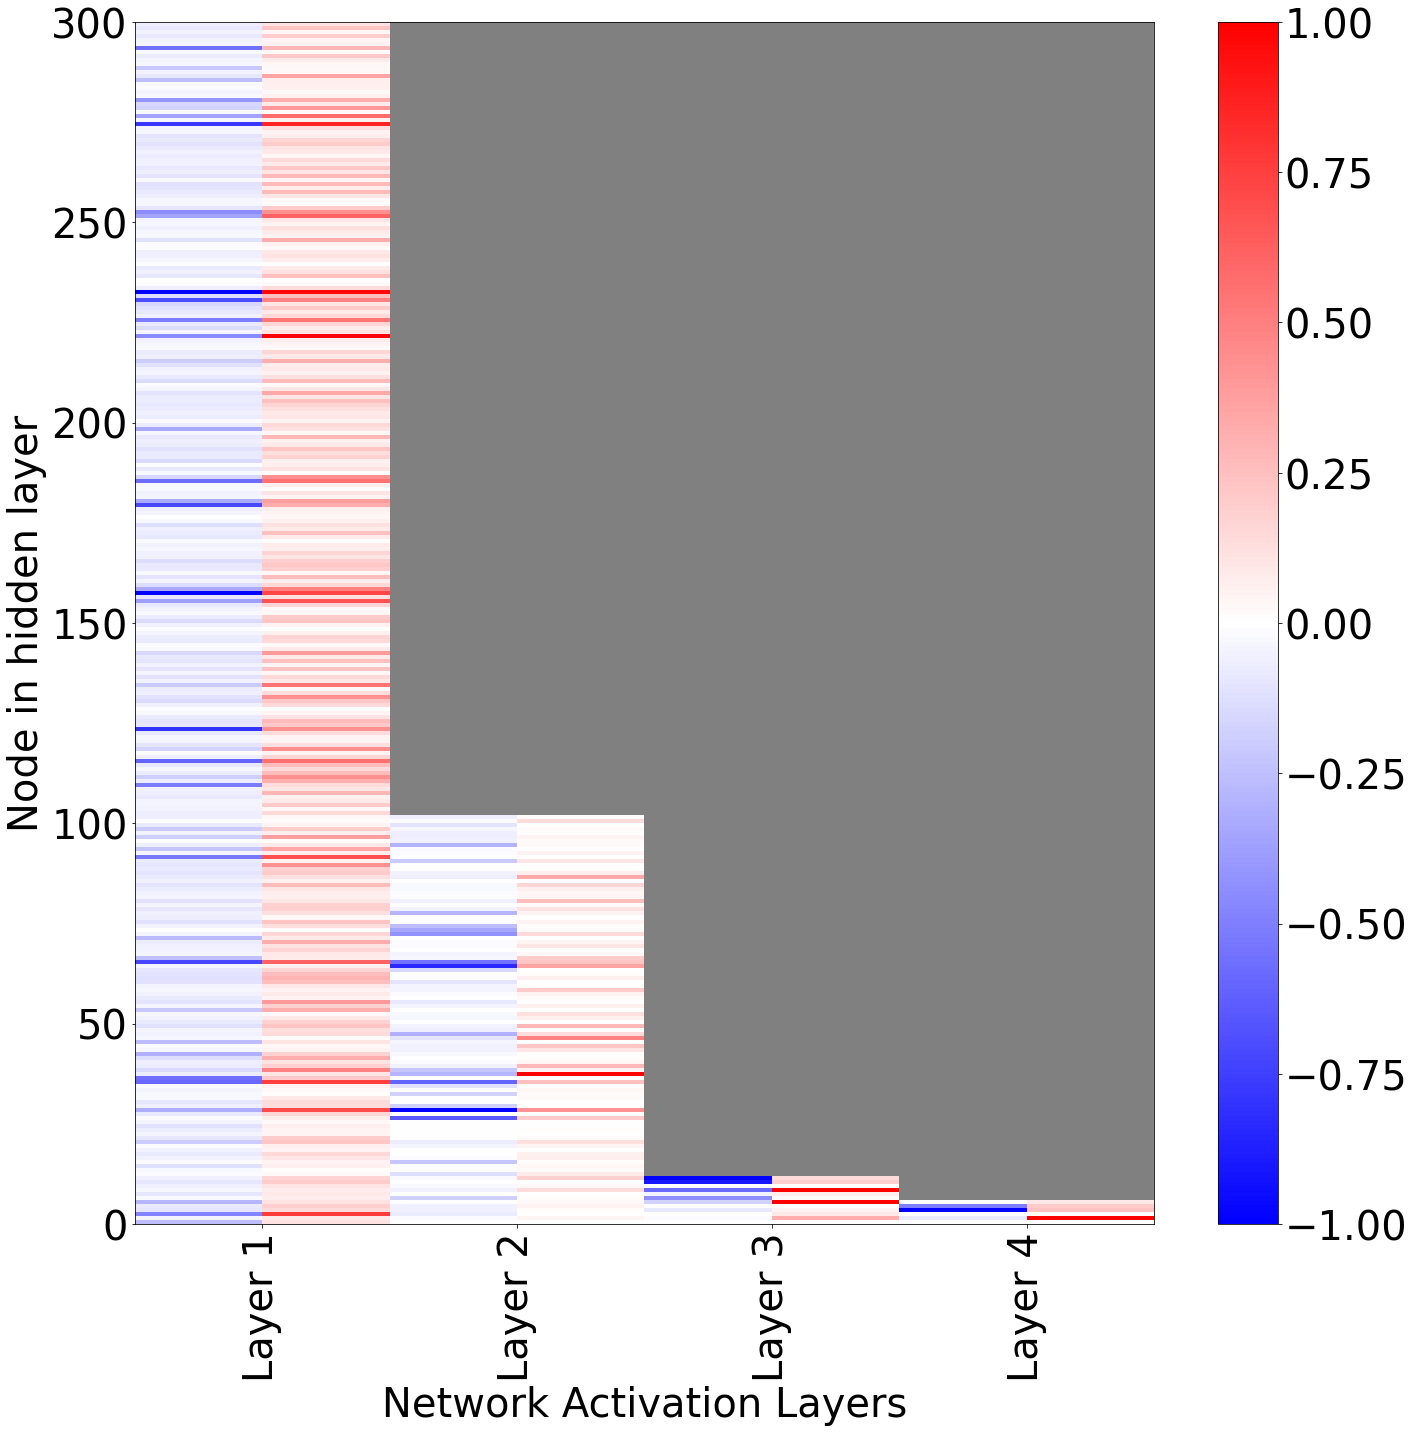

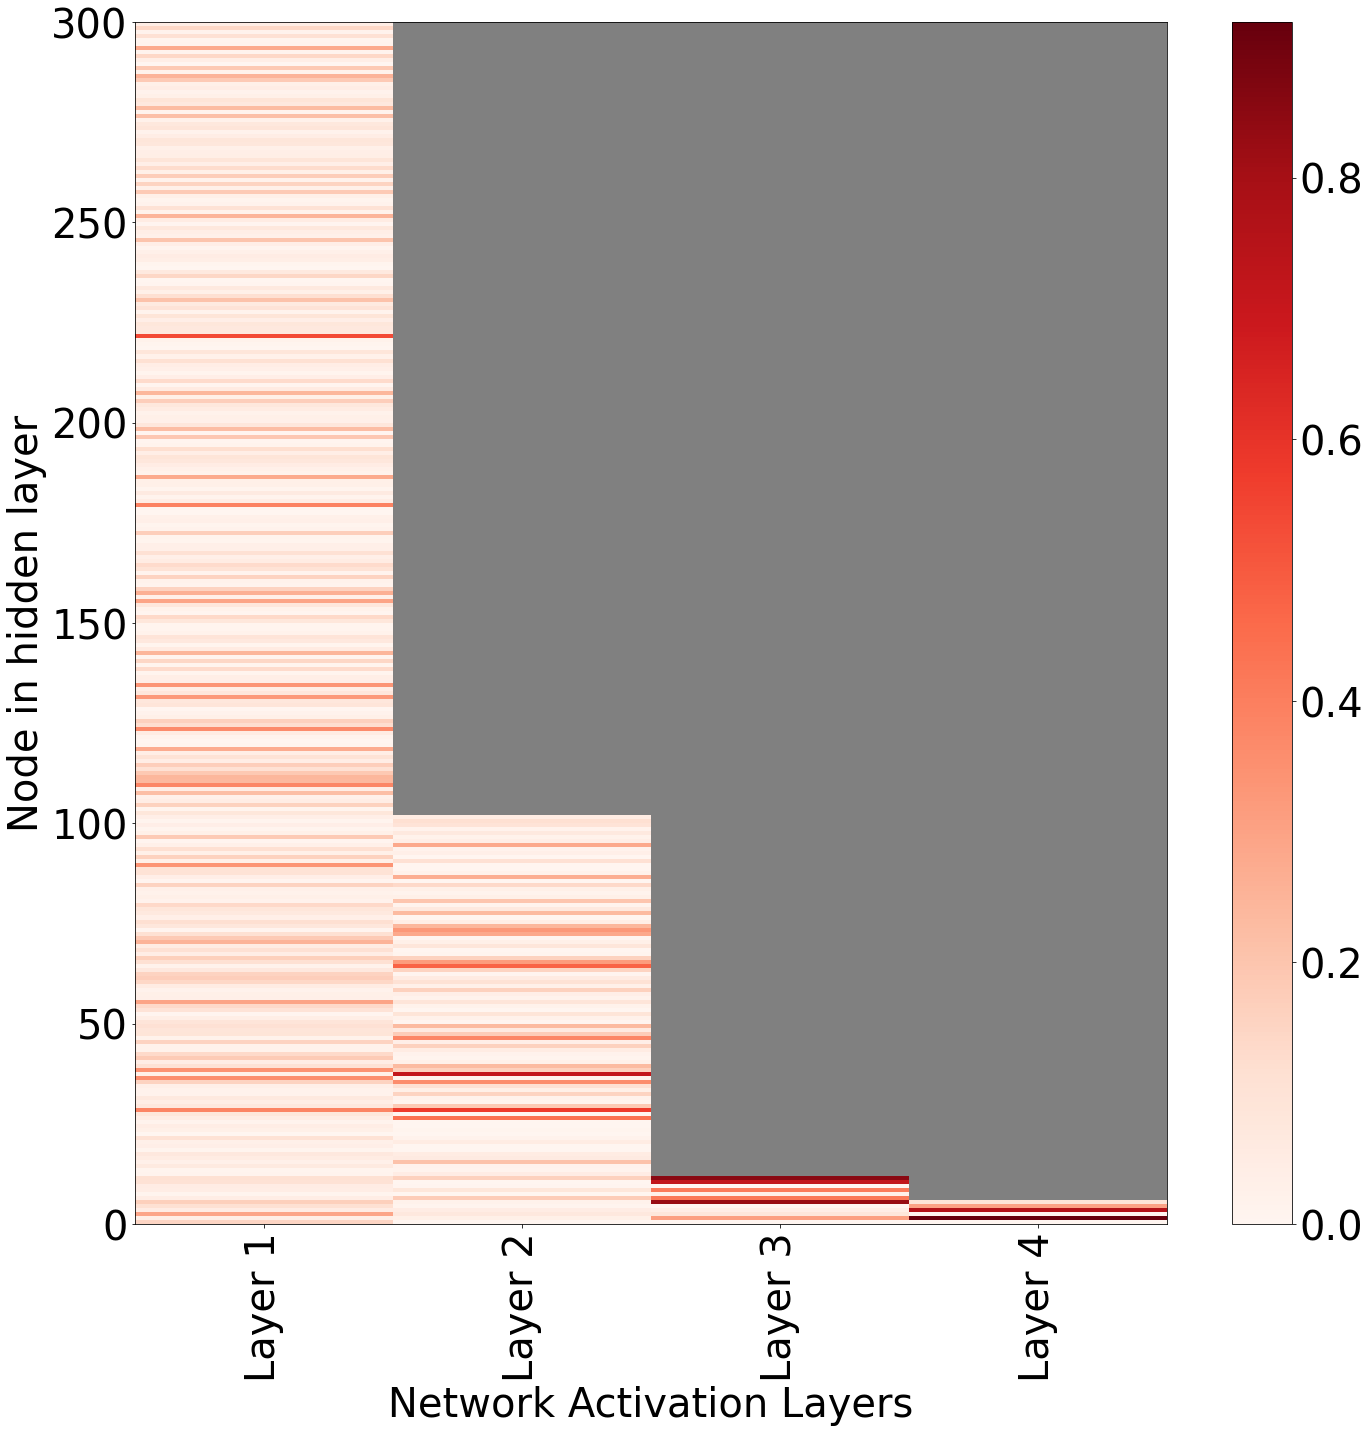

Sparsity measure (RNA < 0.2) for background jets:  0.8690476190476191
Sparsity measure (RNA < 0.2) for signal jets:  0.8809523809523809
Overall sparsity measure (RNA < 0.2):  0.8184523809523809


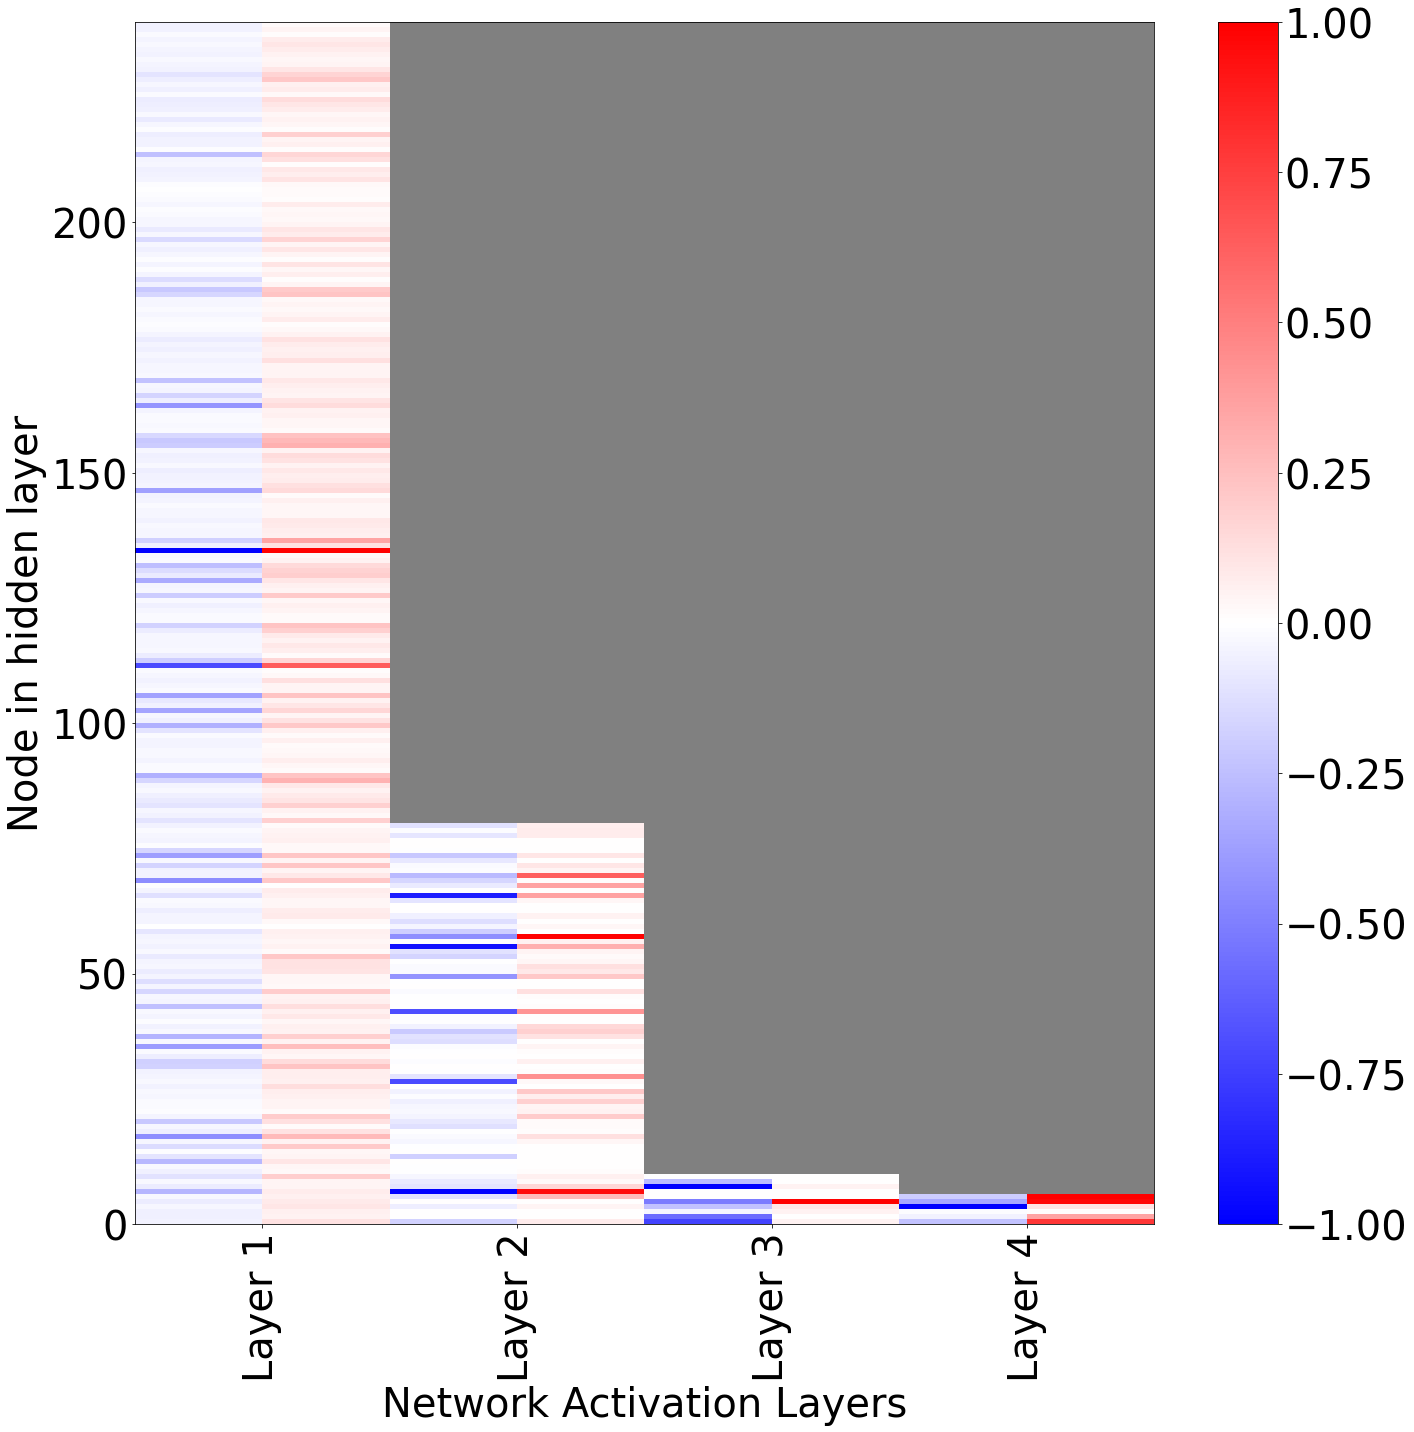

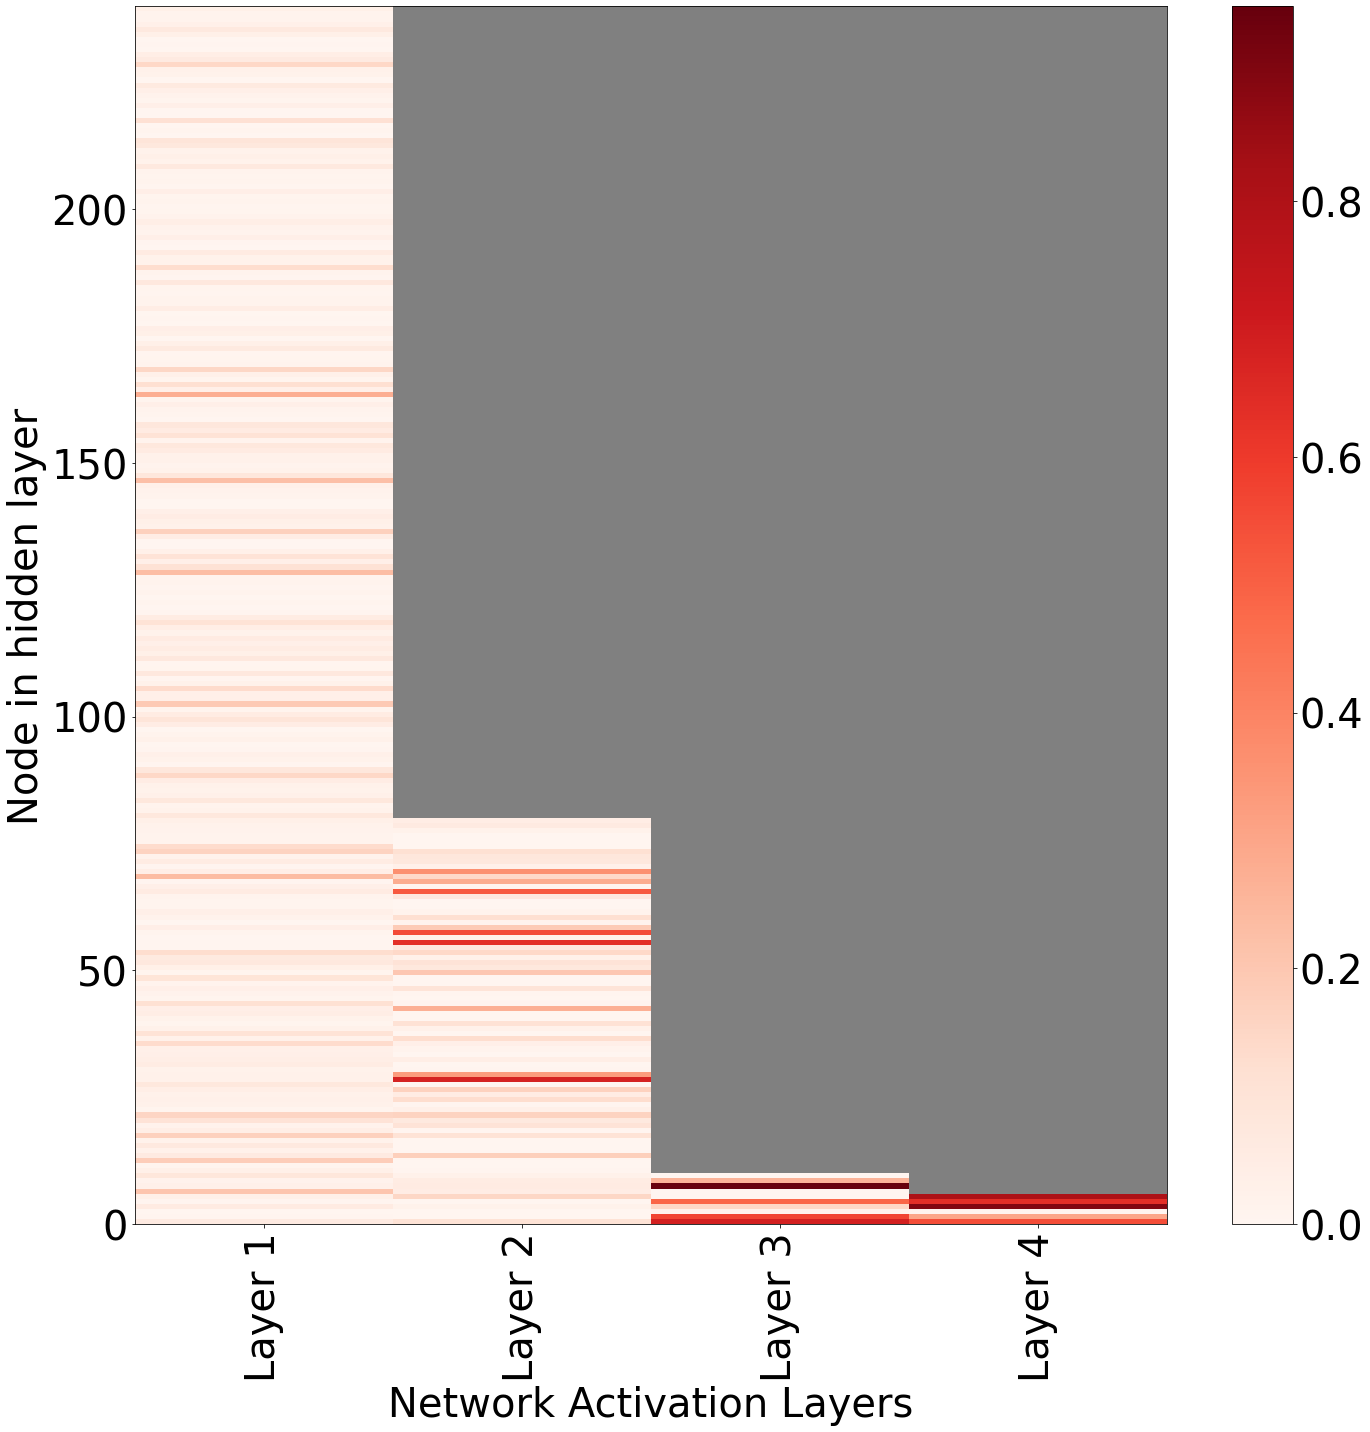

Sparsity measure (RNA < 0.2) for background jets:  0.8848484848484849
Sparsity measure (RNA < 0.2) for signal jets:  0.8606060606060606
Overall sparsity measure (RNA < 0.2):  0.8090909090909091


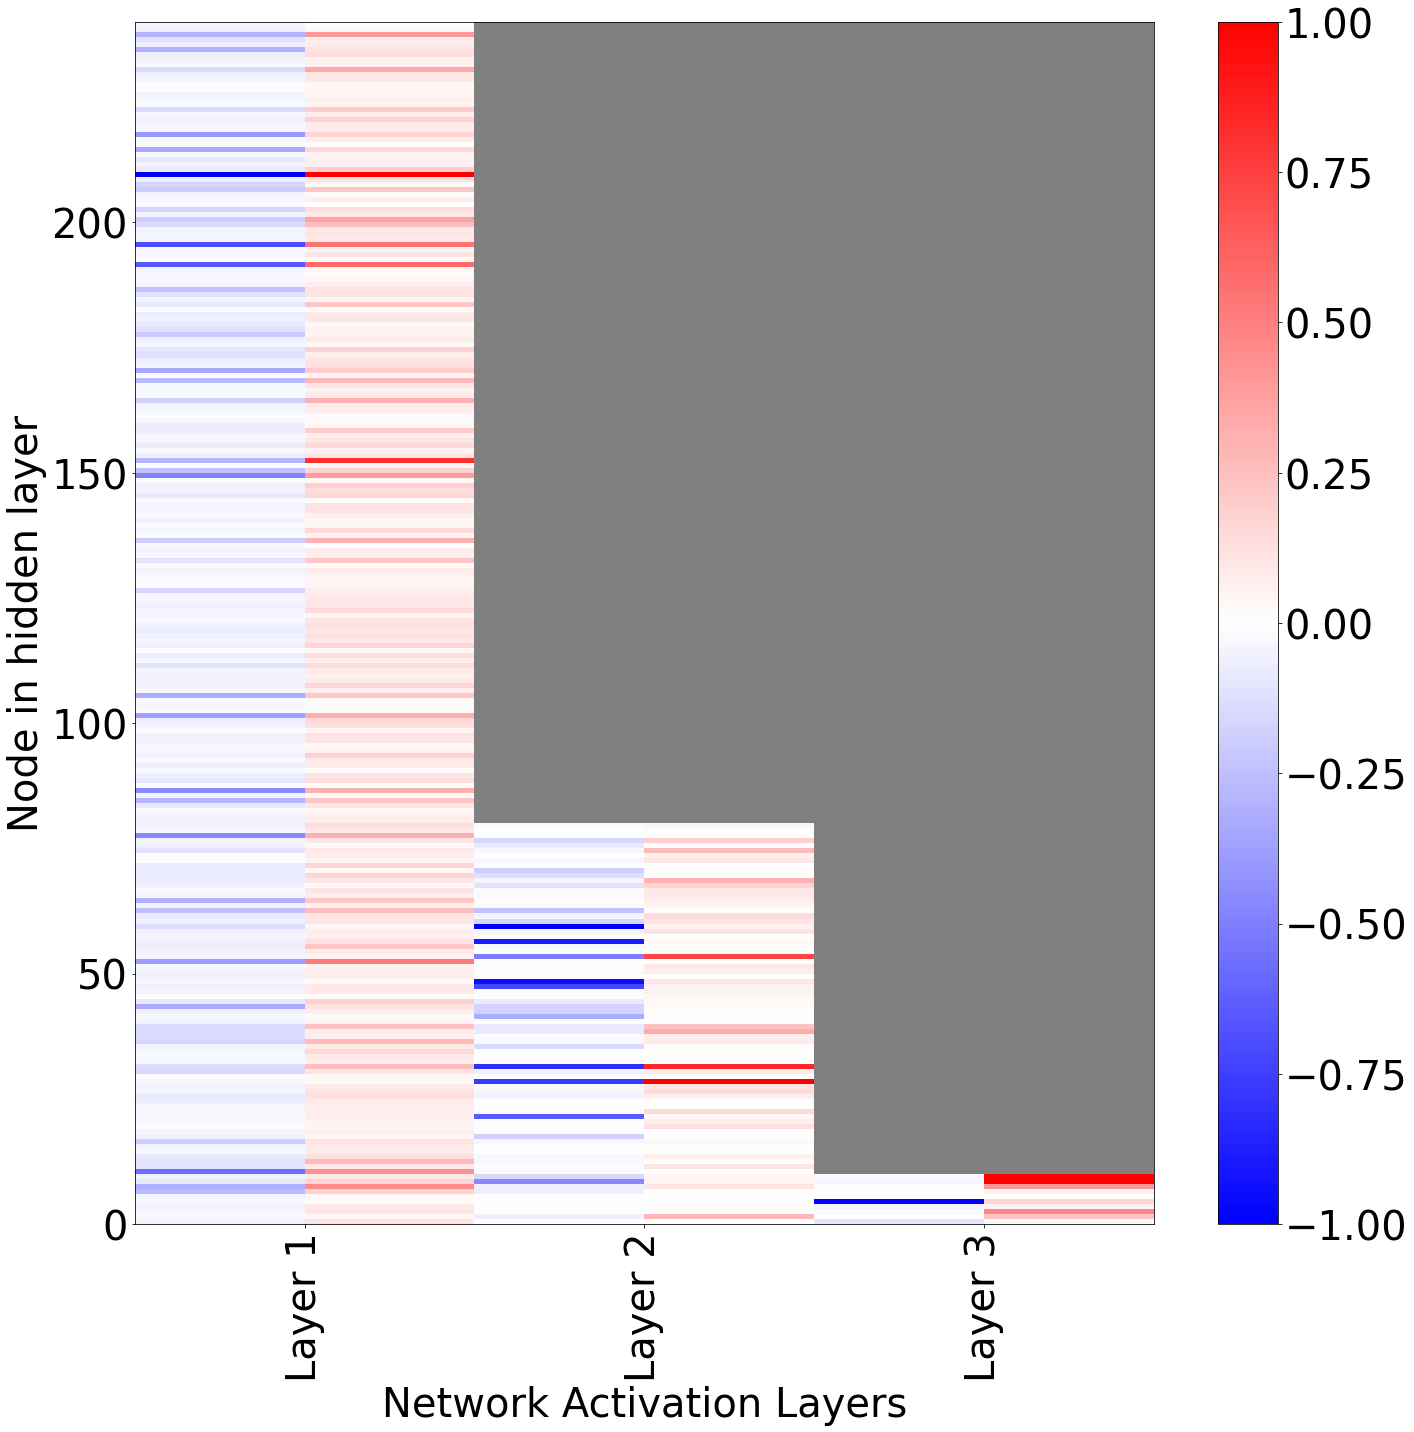

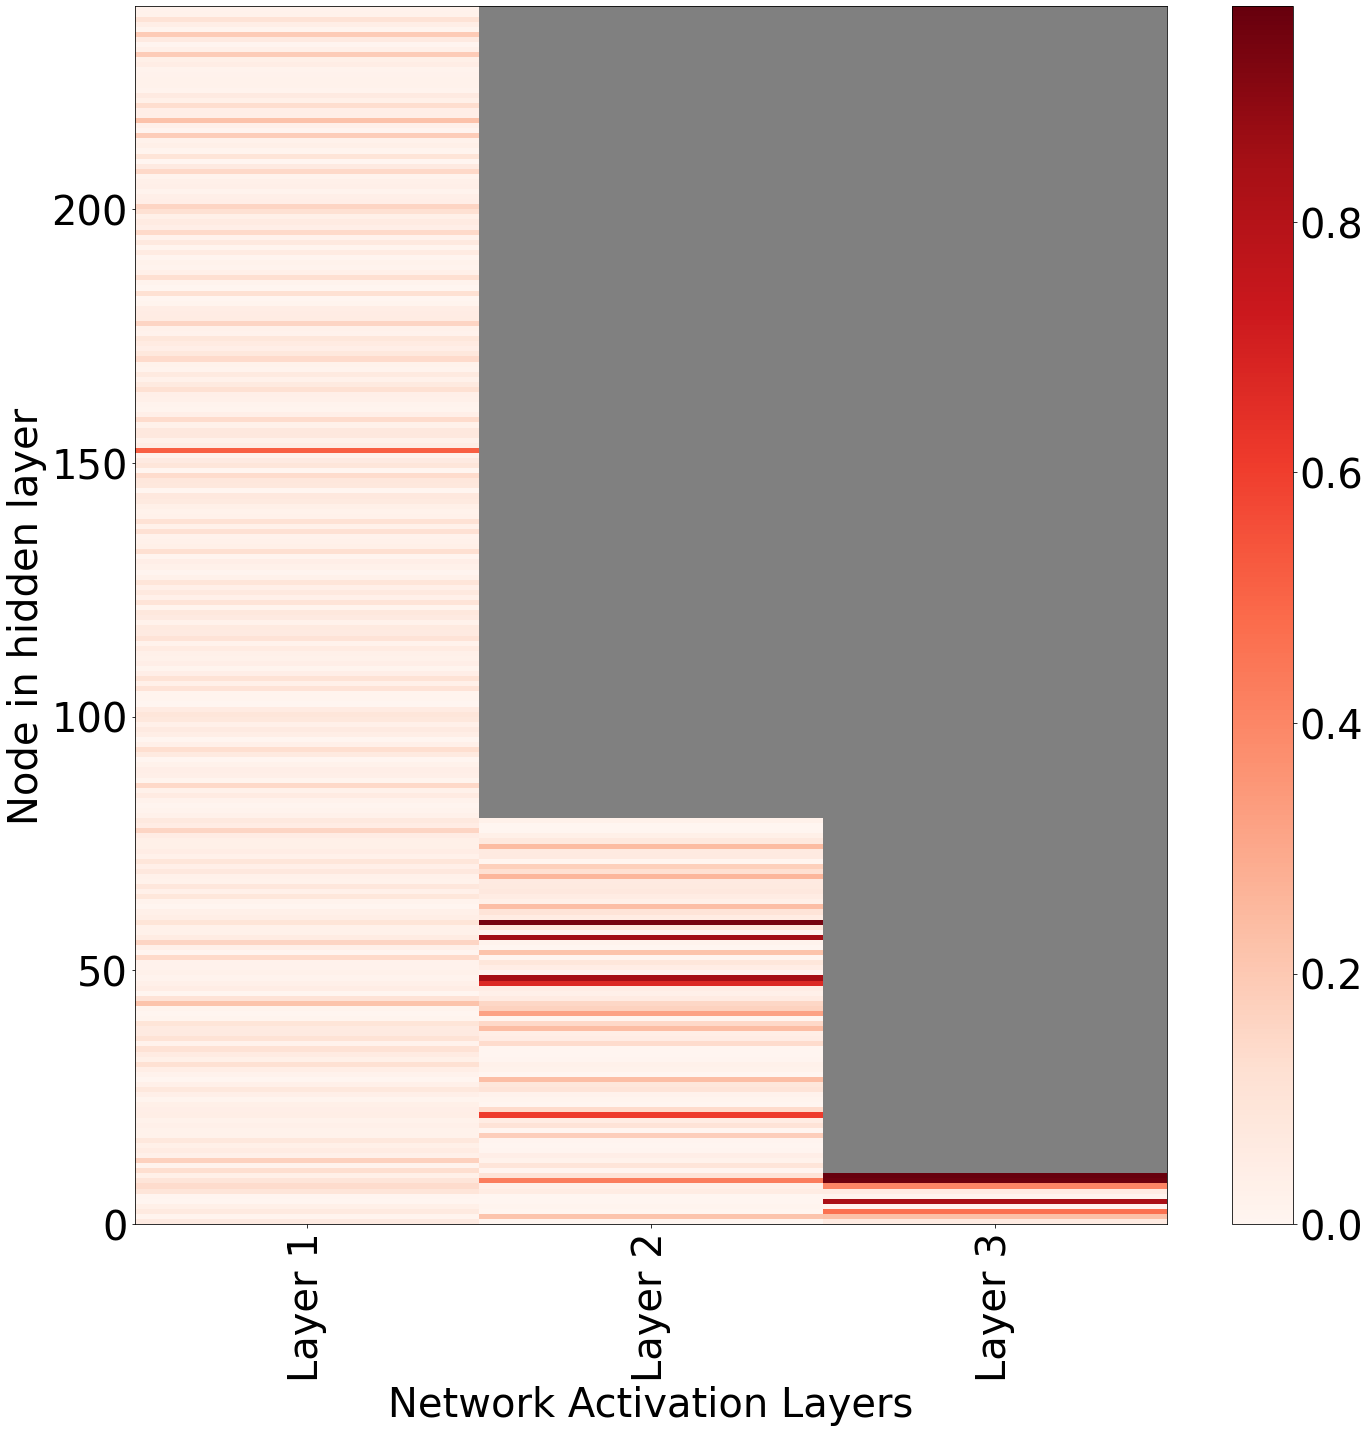

Sparsity measure (RNA < 0.2) for background jets:  0.8467741935483871
Sparsity measure (RNA < 0.2) for signal jets:  0.8306451612903226
Overall sparsity measure (RNA < 0.2):  0.7580645161290323


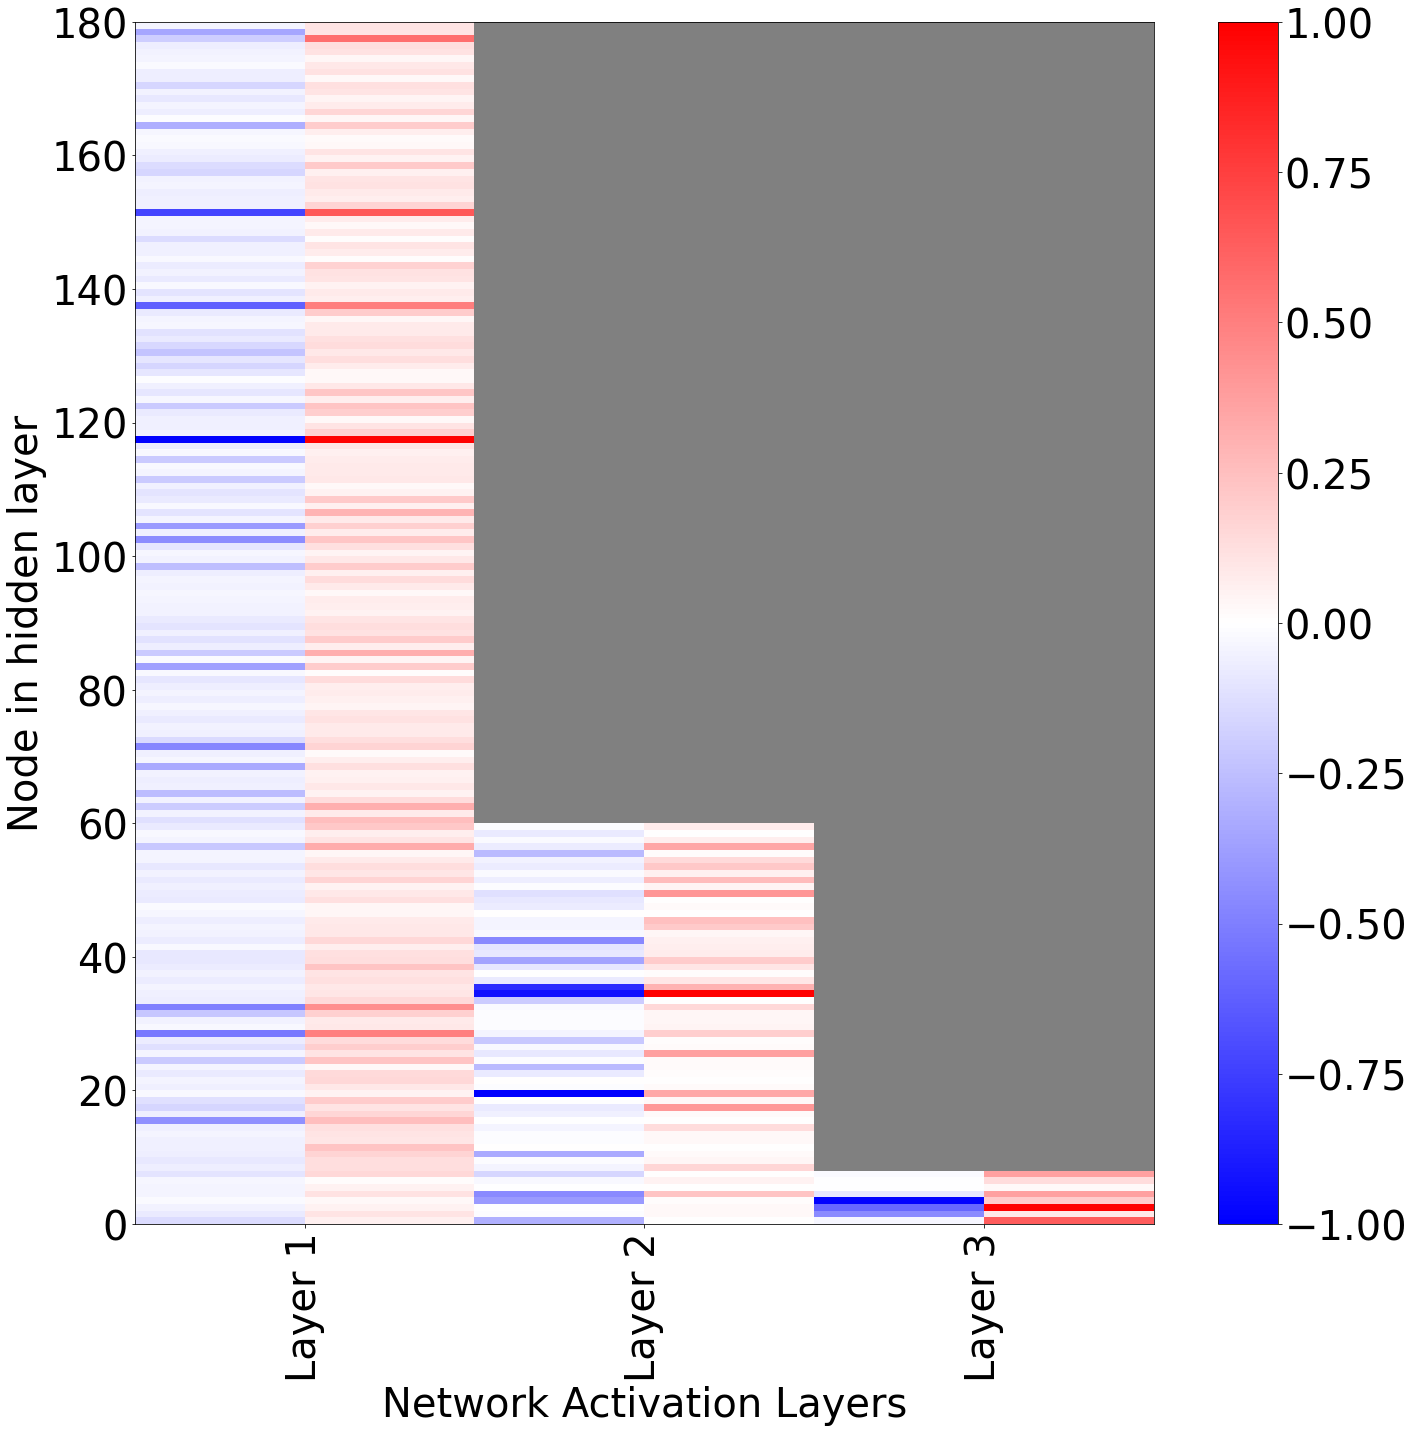

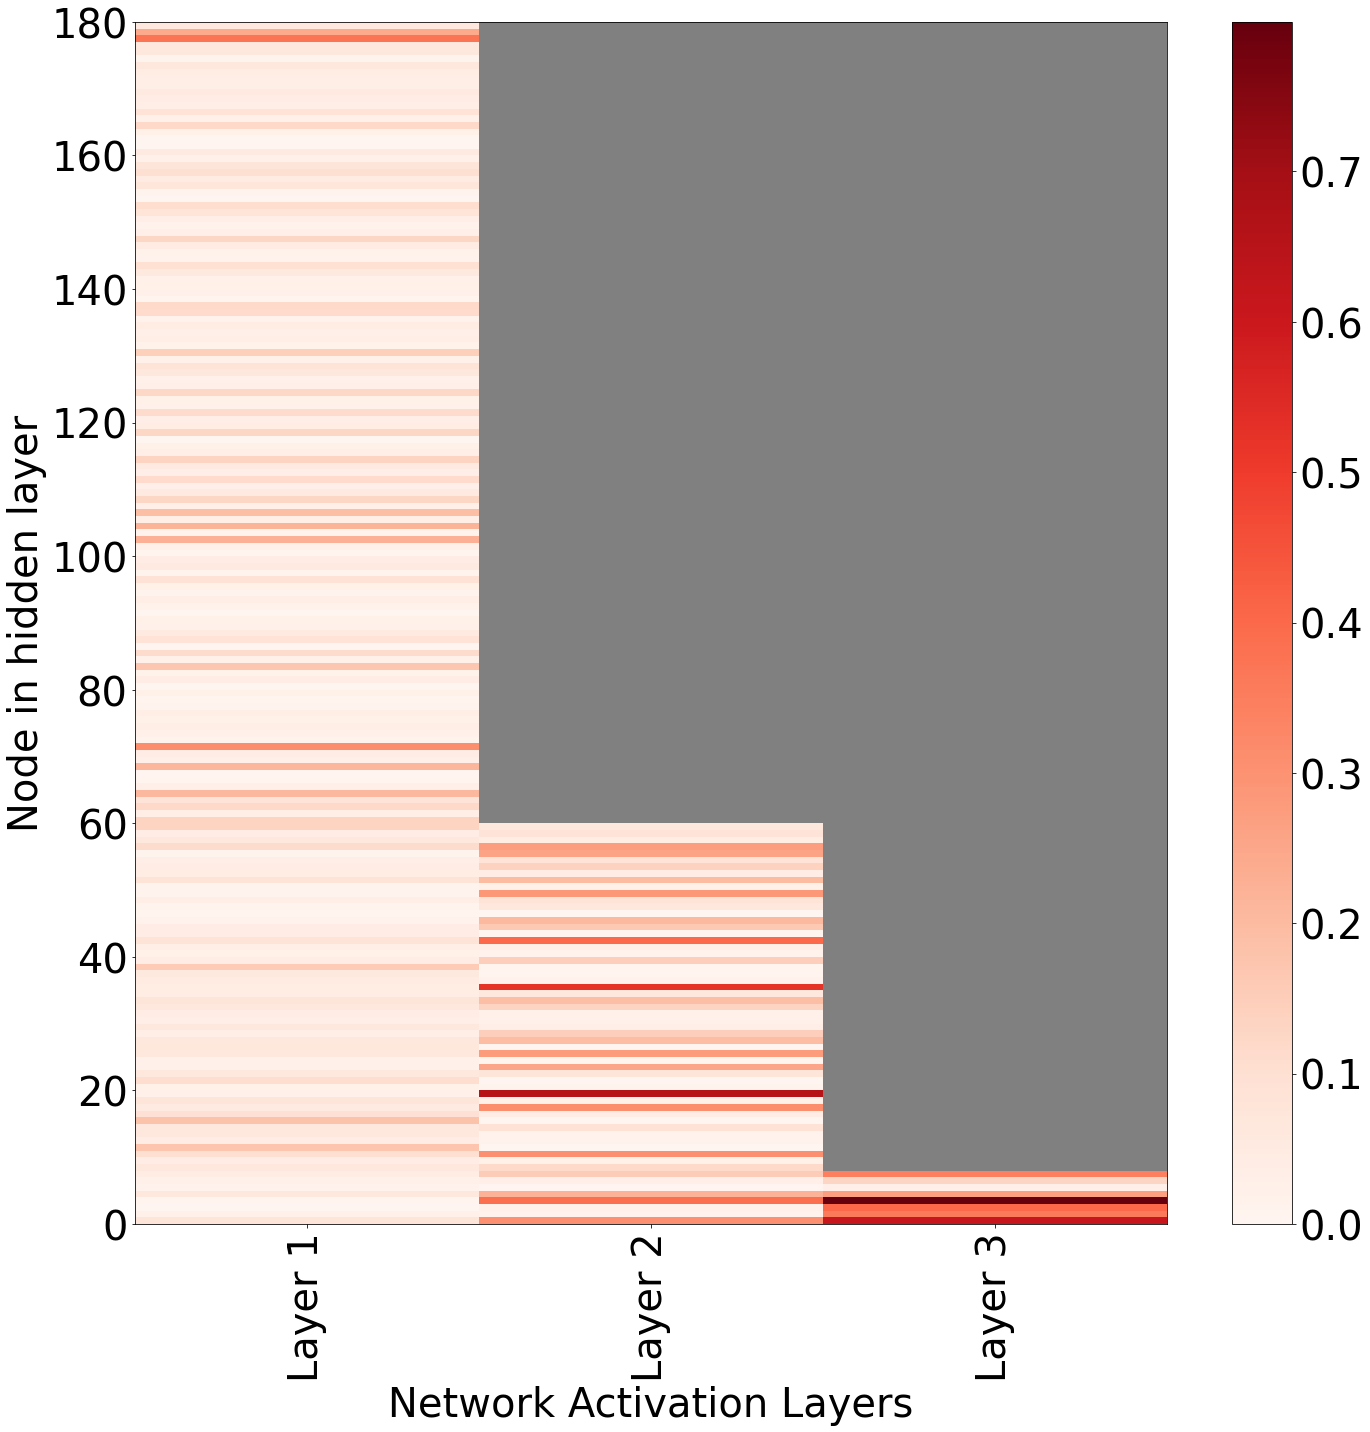

Sparsity measure (RNA < 0.2) for background jets:  0.7349397590361446
Sparsity measure (RNA < 0.2) for signal jets:  0.6807228915662651
Overall sparsity measure (RNA < 0.2):  0.5843373493975904


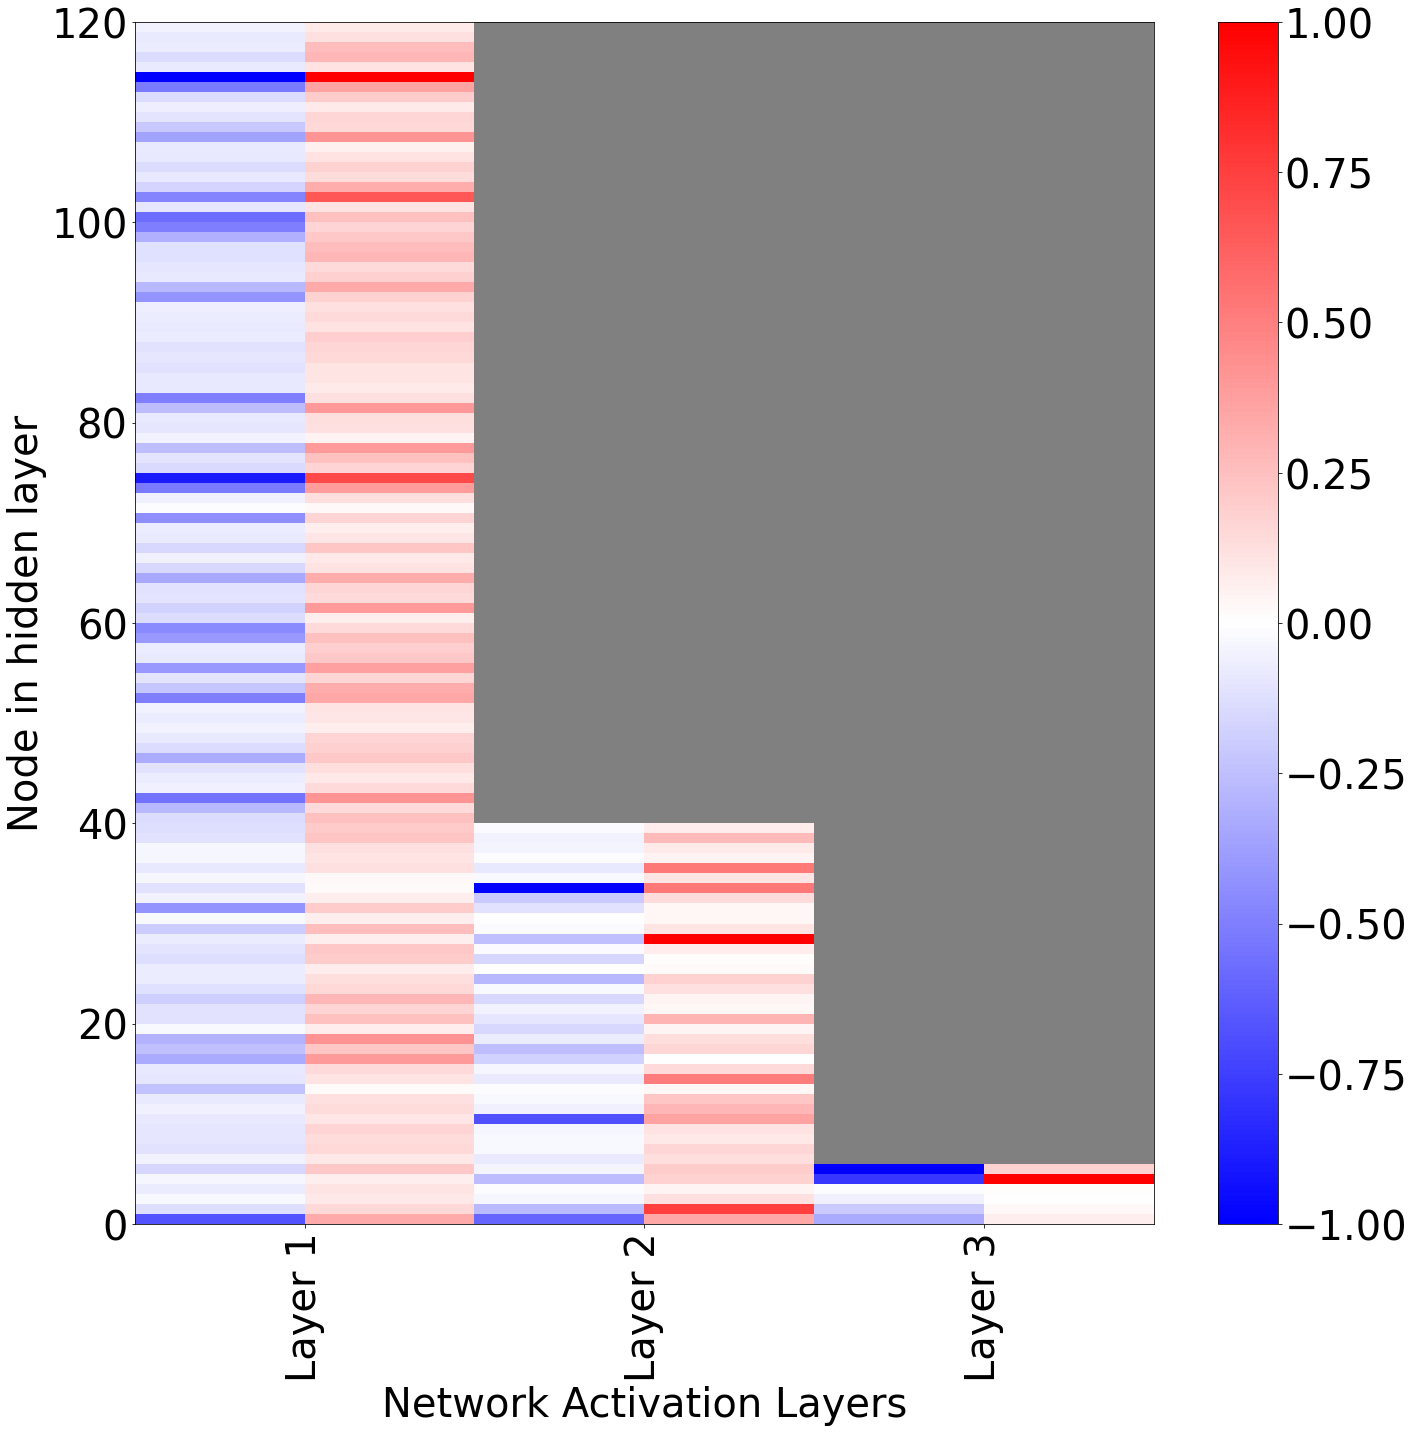

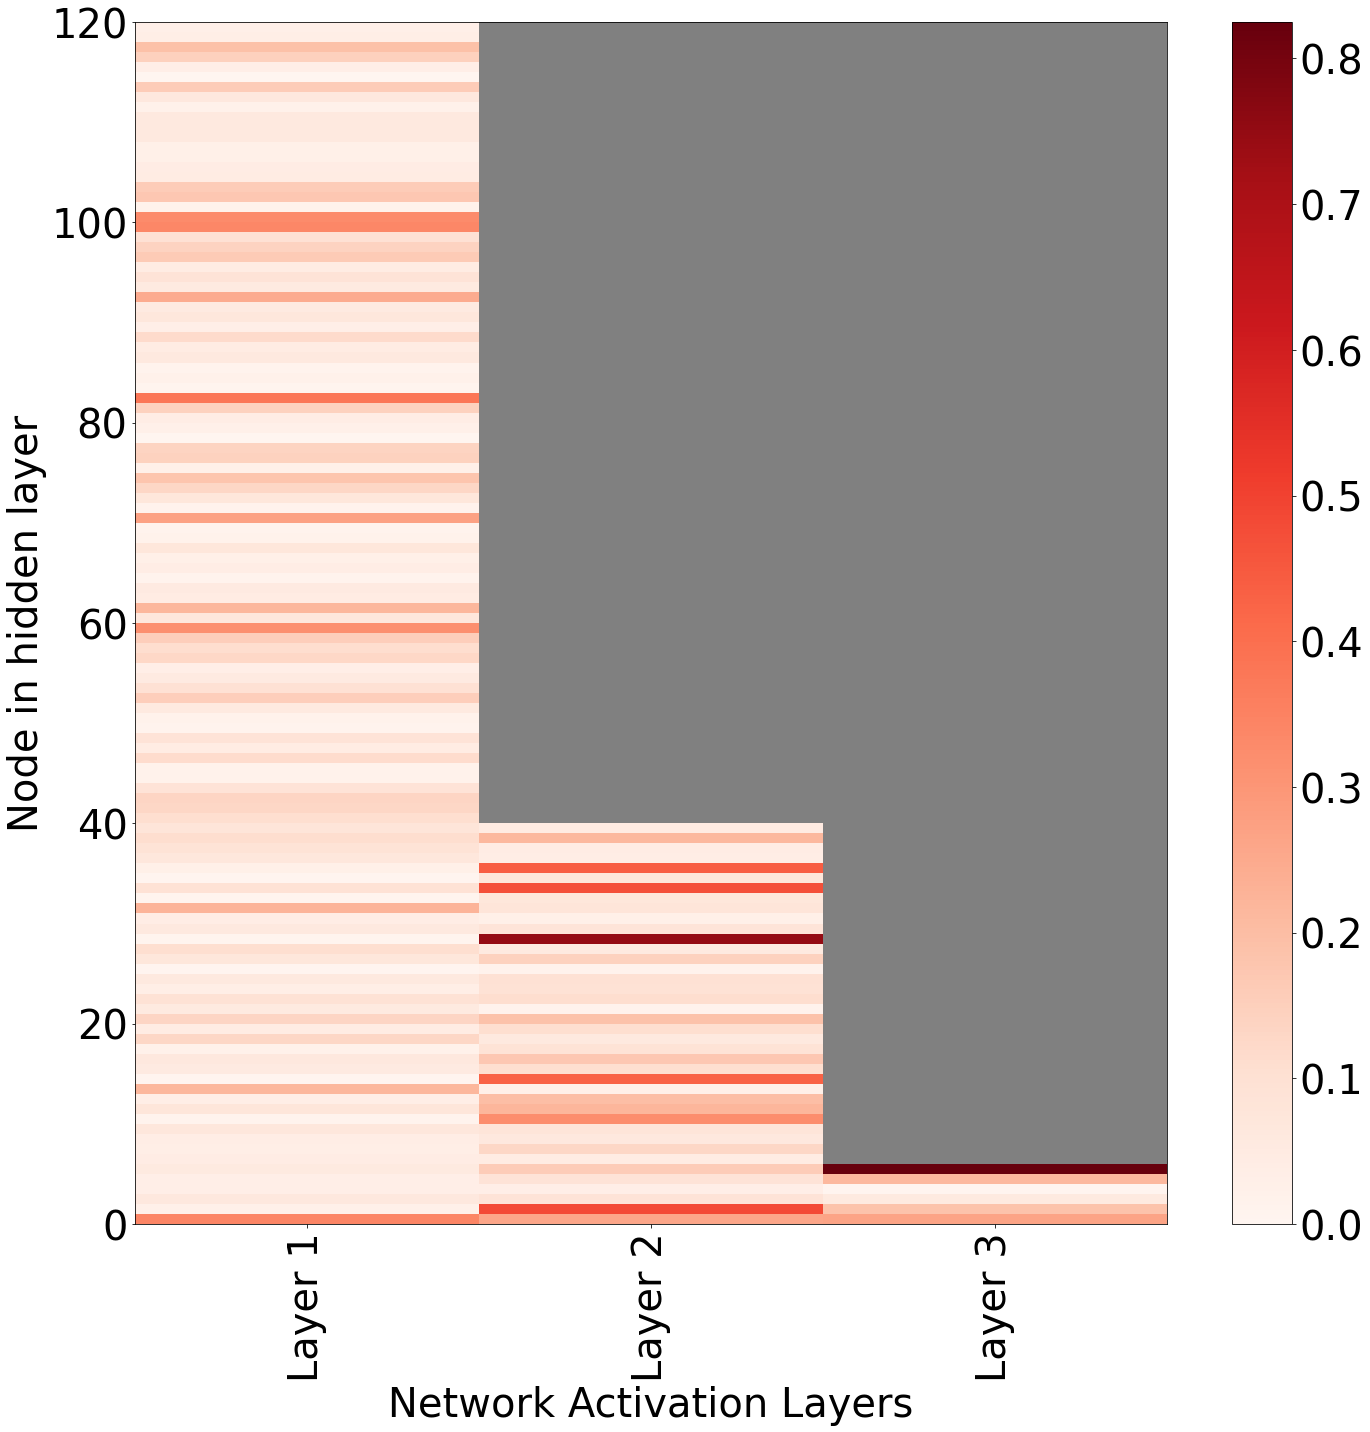

In [51]:
#Can change to '', '_pt0','_pt', '_30', or '_standardize_pt'
modes = ['', '_v1', '_v2', '_v3', '_v4']
sparsities ={}

for mode in modes:
    df_test2 = df_test.copy()
    if mode == '_pt0':
        #Get rid of pt_0 column
        df_test2 = df_test2.loc[:, df_test2.columns != 'pt_0']
    elif mode == '_pt':
        pt_cols = [col for col in df_test2.columns if 'pt' in col]
        df_test2 = df_test2.drop(pt_cols, axis=1)
    elif mode == '_30':
        df_test2 = df_test2.iloc[:,:30]
    elif mode == '_standardize_pt':
        pt_cols = [col for col in df_test2.columns if 'pt' in col]
        df_test2[pt_cols] = (df_test2[pt_cols] - df_test2[pt_cols].mean())/df_test2[pt_cols].std()
        
    
    feats = np.array(df_test2)
    means = np.array(df_test2.mean(0))
    feat_names = list(df_test2.columns)


#     print("Features shape: ", feats.shape)
#     print("Means shape: ", means.shape)
#     print("Results shape: ", labels.shape)
    model = load_model("../../models/TopoDNN/topodnnmodels/topodnnmodel"+mode)
    # model.summary()
    nparams = 0
    for w in model.trainable_weights: 
        nparams += np.prod(w.shape)
    FiringMatrix_0, layer_tags = NeuronFiringEvaluator(model, feats[labels==0])
    FiringMatrix_1, layer_tags = NeuronFiringEvaluator(model, feats[labels==1])
    s = ActivationMapPlotter(FiringMatrix_0, FiringMatrix_1, layer_tags, tag=mode, save=True)
    sparsities[mode.strip('_') if mode else 'baseline']= list(s) + [nparams]

In [52]:
for mode in sparsities:
    print(mode, sparsities[mode][3], sparsities[mode][2])

baseline 59323 0.7047619047619048
v1 42003 0.8184523809523809
v2 41941 0.8090909090909091
v3 27737 0.7580645161290323
v4 16013 0.5843373493975904
